In [279]:
# ！pip install functorch
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import pandas as pd
import scipy
from scipy import stats
import numpy as np
from os import path

In [280]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [281]:
MA_DAYS = 25
trading_days_in_year = 252

# Import raw data from yahoo finance

In [282]:
from google.colab import drive
drive.mount('/content/drive')
data_files_path_prefix = "/content/drive/MyDrive"
data_files_path = "ML-Portfolio-Data"
data_files_path = path.join(data_files_path_prefix, data_files_path)

high_risk_file = 'SPY.csv'
low_risk_file = 'O9P.SI.csv'
high_risk = pd.read_csv(path.join(data_files_path, high_risk_file))
low_risk = pd.read_csv(path.join(data_files_path, low_risk_file))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [283]:
# Read files from the same directory
#high_risk = pd.read_csv('SPY.csv')
#low_risk = pd.read_csv('O9P.SI.csv')

In [284]:
high_risk = high_risk[:1008]
low_risk = low_risk[:1008]
print(high_risk.shape)
print(low_risk.shape)

(1008, 7)
(1008, 7)


In [285]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-28,245.169998,245.199997,244.089996,244.570007,224.240860,40565600
1,2017-08-29,243.059998,245.149994,242.929993,244.850006,224.497574,51135700
2,2017-08-30,244.830002,246.320007,244.619995,246.009995,225.561142,62030800
3,2017-08-31,246.720001,247.770004,246.050003,247.490005,226.918106,103803900
4,2017-09-01,247.919998,248.330002,247.669998,247.839996,227.239059,62007000


In [286]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-28,10.90,10.90,10.88,10.88,10.88,7400
1,2017-08-29,10.89,10.90,10.89,10.90,10.90,1400
2,2017-08-30,10.94,10.94,10.94,10.94,10.94,5300
3,2017-08-31,10.92,10.96,10.92,10.93,10.93,30700
4,2017-09-04,10.89,10.89,10.80,10.83,10.83,59800


# ML Portfolio

## Enrich data

### Calculate daily returns

In [287]:
def add_daily_return(market_data):
    market_data["Daily Return"]  = market_data['Close'] - market_data['Open']

add_daily_return(high_risk)
add_daily_return(low_risk)

### Calculate moving average (MA) of daily returns

In [288]:
def add_moving_average(market_data, ma_days):
    temp_vars = []

    # df = market_data
    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data[temp_var] = market_data["Daily Return"].shift(i)
        temp_vars.append(temp_var)

    market_data["MA"] = market_data[temp_vars].mean(axis=1)

    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data.drop(temp_var, axis = 1, inplace = True)

add_moving_average(high_risk, MA_DAYS)
add_moving_average(low_risk, MA_DAYS)


In [289]:
high_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
1003,2021-08-23,445.160004,448.230011,443.440002,447.260010,440.990021,54973000,2.100006,0.880400
1004,2021-08-24,447.970001,448.540009,447.420013,447.970001,441.690033,38744700,0.000000,0.665200
1005,2021-08-25,448.170013,449.459991,447.769989,448.910004,442.616913,40529700,0.739991,0.606400
1006,2021-08-26,448.609985,448.859985,446.160004,446.260010,440.004089,57829600,-2.349975,0.483601
1007,2021-08-27,447.119995,450.649994,447.059998,450.250000,443.938110,77235100,3.130005,0.512001


In [290]:
low_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
1003,2021-08-24,9.83,9.86,9.81,9.84,9.84,19960,0.01,-0.0316
1004,2021-08-25,9.90,9.90,9.85,9.86,9.86,102205,-0.04,-0.0320
1005,2021-08-26,9.89,9.89,9.86,9.86,9.86,66520,-0.03,-0.0296
1006,2021-08-27,9.90,9.90,9.86,9.88,9.88,68015,-0.02,-0.0308
1007,2021-08-30,9.79,9.79,9.77,9.78,9.78,1017465,-0.01,-0.0312


### Calculate ROE

In [291]:
def add_roe(market_data):    
    market_data["Prev Close"] = market_data["Close"].shift(1)
    market_data["ROE"] = (market_data["Close"] - market_data["Prev Close"]) / market_data['Prev Close']

add_roe(high_risk)
add_roe(low_risk)

In [292]:
def add_roe_binary(market_data, tau=-0.005):    
    market_data["ROE Binary"] = np.where(market_data["ROE"].values < tau, 0, 1)

add_roe_binary(high_risk)
add_roe_binary(low_risk)

In [293]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
0,2017-08-28,245.169998,245.199997,244.089996,244.570007,224.240860,40565600,-0.599991,-0.599991,NaN,NaN,1
1,2017-08-29,243.059998,245.149994,242.929993,244.850006,224.497574,51135700,1.790008,0.595009,244.570007,0.001145,1
2,2017-08-30,244.830002,246.320007,244.619995,246.009995,225.561142,62030800,1.179993,0.790003,244.850006,0.004738,1
3,2017-08-31,246.720001,247.770004,246.050003,247.490005,226.918106,103803900,0.770004,0.785004,246.009995,0.006016,1
4,2017-09-01,247.919998,248.330002,247.669998,247.839996,227.239059,62007000,-0.080002,0.612002,247.490005,0.001414,1


In [294]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
0,2017-08-28,10.90,10.90,10.88,10.88,10.88,7400,-0.02,-0.020000,NaN,NaN,1
1,2017-08-29,10.89,10.90,10.89,10.90,10.90,1400,0.01,-0.005000,10.88,0.001838,1
2,2017-08-30,10.94,10.94,10.94,10.94,10.94,5300,0.00,-0.003333,10.90,0.003670,1
3,2017-08-31,10.92,10.96,10.92,10.93,10.93,30700,0.01,0.000000,10.94,-0.000914,1
4,2017-09-04,10.89,10.89,10.80,10.83,10.83,59800,-0.06,-0.012000,10.93,-0.009149,0


## Build feature space

In [295]:
def remove_for_ma(market_data, ma_days):
  return market_data[ma_days:]

high_risk = remove_for_ma(high_risk, MA_DAYS)
low_risk = remove_for_ma(low_risk, MA_DAYS)

In [296]:
print(high_risk.shape)

(983, 12)


In [297]:
def standardize_columns(market_data, columns):
  for column in columns:
    market_data[column] = market_data[column]/market_data[column].std()

standardize_columns(high_risk, ['Volume', 'Daily Return', 'MA'])
standardize_columns(low_risk, ['Volume', 'Daily Return', 'MA'])

<ipython-input-297-d0986728a5f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_data[column] = market_data[column]/market_data[column].std()


In [298]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
25,2017-10-03,252.320007,252.889999,252.229996,252.860001,232.992355,1.367891,0.208144,0.708710,252.320007,0.002140,1
26,2017-10-04,252.690002,253.440002,252.559998,253.160004,233.268799,1.145610,0.181166,0.583476,252.860001,0.001186,1
27,2017-10-05,253.539993,254.679993,253.199997,254.660004,234.650909,1.300584,0.431716,0.577785,253.160004,0.005925,1
28,2017-10-06,254.149994,254.699997,253.850006,254.369995,234.383713,1.651169,0.084801,0.525604,254.660004,-0.001139,1
29,2017-10-09,254.630005,254.699997,253.649994,253.949997,233.996689,0.733043,-0.262114,0.468679,254.369995,-0.001651,1


In [299]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
25,2017-10-03,10.86,10.87,10.86,10.86,10.86,0.659605,0.000000,-0.383962,10.85,0.000922,1
26,2017-10-04,10.86,10.86,10.86,10.86,10.86,0.000000,0.000000,-0.393561,10.86,0.000000,1
27,2017-10-05,10.89,10.89,10.88,10.88,10.88,0.172782,-0.045821,-0.403161,10.86,0.001842,1
28,2017-10-06,10.89,10.89,10.87,10.88,10.88,0.371247,-0.045821,-0.422359,10.88,0.000000,1
29,2017-10-09,10.88,10.88,10.85,10.88,10.88,0.254503,0.000000,-0.364764,10.88,0.000000,1


In [300]:
def to_X_train_features(low_risk, high_risk):
  high_risk_train = high_risk[:1000]
  low_risk_train = low_risk[:1000]
  return np.vstack((high_risk_train['Daily Return'], high_risk_train['MA'], high_risk_train['Volume'], low_risk_train['Daily Return'], low_risk_train['MA'], low_risk_train['Volume']))

X = to_X_train_features(low_risk, high_risk).T
print(X.shape, X)

(983, 6) [[ 0.20814449  0.7087102   1.36789127  0.         -0.38396238  0.65960516]
 [ 0.18116558  0.58347574  1.14561011  0.         -0.39356144  0.        ]
 [ 0.43171613  0.57778499  1.30058409 -0.04582138 -0.4031605   0.17278153]
 ...
 [ 0.28523475  1.43829291  0.82981674 -0.13746413 -0.71033041  0.77658292]
 [-0.90581443  1.1470315   1.18401988 -0.09164275 -0.73912759  0.79403619]
 [ 1.20648249  1.2143914   1.58133367 -0.04582138 -0.74872665 11.87832143]]


In [301]:
def to_Y_train_features(low_risk, high_risk):
  high_risk_train = high_risk[0:1000]
  return high_risk_train['ROE Binary'].values

Y = to_Y_train_features(low_risk, high_risk)
print(Y.shape, Y)

(983,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0
 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0
 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0
 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 1

## Build graph

In [302]:
X_tensor = torch.from_numpy(X)
print(type(X), X.shape, X_tensor.size())
Y_tensor = torch.from_numpy(Y).double()
print(type(Y), Y.shape, Y_tensor.size())

<class 'numpy.ndarray'> (983, 6) torch.Size([983, 6])
<class 'numpy.ndarray'> (983,) torch.Size([983])


In [303]:
a = torch.randn((6), requires_grad=True, dtype=torch.double)
b = torch.randn((6), requires_grad=True, dtype=torch.double)
print(a, a.size(), b, b.size())

tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863],
       dtype=torch.float64, requires_grad=True) torch.Size([6]) tensor([ 2.2082, -0.6380,  0.4617,  0.2674,  0.5349,  0.8094],
       dtype=torch.float64, requires_grad=True) torch.Size([6])


In [304]:
lr = 1e-1
n_epochs = 500
torch.manual_seed(42)
lambda1 = 1e-3 #0.5
lambda2 = 1e-3 #0.5

loss_fn = nn.BCELoss()
optimizer = optim.SGD([a, b], lr=lr)

In [305]:
for epoch in range(n_epochs):
  
    yhat = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))

    loss = loss_fn(yhat, Y_tensor)
    loss.backward()   

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}. Loss: {loss}")

    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

Epoch: 0. Loss: 1.6054652614575213
Epoch: 10. Loss: 1.0183867082015894
Epoch: 20. Loss: 0.7591680940236091
Epoch: 30. Loss: 0.6226023509903138
Epoch: 40. Loss: 0.5505343655289984
Epoch: 50. Loss: 0.5093908197922487
Epoch: 60. Loss: 0.48304853431280786
Epoch: 70. Loss: 0.4645685755477289
Epoch: 80. Loss: 0.45073399283496657
Epoch: 90. Loss: 0.4398778751355094
Epoch: 100. Loss: 0.43105877059186404
Epoch: 110. Loss: 0.4237184658769389
Epoch: 120. Loss: 0.4175218686473746
Epoch: 130. Loss: 0.41227177780217134
Epoch: 140. Loss: 0.4078548240241707
Epoch: 150. Loss: 0.4041993849195518
Epoch: 160. Loss: 0.4012414351363049
Epoch: 170. Loss: 0.3989037711286092
Epoch: 180. Loss: 0.39709267338823123
Epoch: 190. Loss: 0.3957072618222237
Epoch: 200. Loss: 0.3946519134866905
Epoch: 210. Loss: 0.39384487071885654
Epoch: 220. Loss: 0.393221367878691
Epoch: 230. Loss: 0.3927327455435196
Epoch: 240. Loss: 0.3923436545963472
Epoch: 250. Loss: 0.39202887099630135
Epoch: 260. Loss: 0.3917704881043872
Epoch:

## Build efficient frontier

In [306]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))
  print(y_test)

tensor([8.8712e-01, 8.1880e-01, 9.0748e-01, 8.5849e-01, 5.6139e-01, 7.2338e-01,
        8.0662e-01, 7.3600e-01, 7.3141e-01, 7.2886e-01, 8.8288e-01, 6.5808e-01,
        8.8021e-01, 8.7035e-01, 4.8500e-01, 7.8670e-01, 7.2756e-01, 6.9909e-01,
        9.3119e-01, 7.7524e-01, 7.3233e-01, 6.1997e-01, 7.6104e-01, 8.3839e-01,
        8.0030e-01, 6.9464e-01, 8.0230e-01, 8.8116e-01, 7.9602e-01, 8.6394e-01,
        8.0019e-01, 7.6406e-01, 8.9713e-01, 7.4368e-01, 8.6668e-01, 8.9198e-01,
        6.8396e-01, 6.4273e-01, 6.8025e-01, 9.7345e-01, 7.4561e-01, 9.6656e-01,
        9.2522e-01, 4.2230e-01, 8.1441e-01, 7.7693e-01, 7.9186e-01, 8.5078e-01,
        8.0616e-01, 7.4720e-01, 8.0461e-01, 5.6717e-01, 9.6328e-01, 8.0603e-01,
        4.9914e-01, 5.2728e-01, 7.2558e-01, 7.3123e-01, 6.7932e-01, 6.7926e-01,
        6.8114e-01, 4.7929e-01, 9.0989e-01, 9.3556e-01, 8.3747e-01, 9.0838e-01,
        7.9554e-01, 7.2597e-01, 8.1966e-01, 9.1210e-01, 9.4476e-01, 3.8257e-01,
        9.6539e-01, 7.8732e-01, 9.4549e-

### Build ML Portfolio

In [307]:
prob = pd.DataFrame(y_test).astype("float")
display(prob)
rolling_prob = prob.rolling(25).mean().iloc[-1]
display(rolling_prob.to_numpy()[0])

,0
0,0.887115
1,0.818803
2,0.907484
3,0.858486
4,0.561395
...,...
978,0.973960
979,0.855042
980,0.901969
981,0.404727


0.866161986546112

In [308]:
def calculate_ml_portfolio_weights(x, k):
  return 0 if x < k else 1

for k in np.arange(0, 1, 0.1):
  print(calculate_ml_portfolio_weights(rolling_prob.to_numpy()[0], k))

1
1
1
1
1
1
1
1
1
0


In [309]:
k = 0.5
calculate_ml_portfolio_weights_lambda = lambda x: 0 if x < k else 1
calculate_ml_portfolio_weights = np.vectorize(calculate_ml_portfolio_weights_lambda)
# vfunc(x)
# calculate_ml_portfolio_weights = functorch.vmap(ml_portfolio_weights, out_dims=1)
# forecast = 
# portfolio_weights = calculate_ml_portfolio_weights(y_test.numpy())
# print(portfolio_weights)

portfolio_weights = y_test.apply_(calculate_ml_portfolio_weights_lambda)
print(portfolio_weights)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 

In [310]:
Xt = torch.from_numpy(to_X_train_features(low_risk, high_risk).T[-1])
Xt

tensor([ 1.2065,  1.2144,  1.5813, -0.0458, -0.7487, 11.8783],
       dtype=torch.float64)

In [311]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(Xt, a)) / (torch.exp (torch.matmul(Xt, a)) + torch.exp(torch.matmul(Xt, b)))
  print(y_test)

tensor(0.9999, dtype=torch.float64)


In [312]:
k = 0.5
calculate_ml_portfolio_weights_lambda = lambda x: 0 if x < k else 1
calculate_ml_portfolio_weights = np.vectorize(calculate_ml_portfolio_weights_lambda)

portfolio_weights = y_test.apply_(calculate_ml_portfolio_weights_lambda)
print(portfolio_weights)

tensor(1., dtype=torch.float64)


# MV Portfolio

In [313]:
def add_daily_return(market_data):
    market_data["Pct Return"]  = market_data['Close'].pct_change()

add_daily_return(high_risk)
add_daily_return(low_risk)

In [314]:
high_risk

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary,Pct Return
25,2017-10-03,252.320007,252.889999,252.229996,252.860001,232.992355,1.367891,0.208144,0.708710,252.320007,0.002140,1,NaN
26,2017-10-04,252.690002,253.440002,252.559998,253.160004,233.268799,1.145610,0.181166,0.583476,252.860001,0.001186,1,0.001186
27,2017-10-05,253.539993,254.679993,253.199997,254.660004,234.650909,1.300584,0.431716,0.577785,253.160004,0.005925,1,0.005925
28,2017-10-06,254.149994,254.699997,253.850006,254.369995,234.383713,1.651169,0.084801,0.525604,254.660004,-0.001139,1,-0.001139
29,2017-10-09,254.630005,254.699997,253.649994,253.949997,233.996689,0.733043,-0.262114,0.468679,254.369995,-0.001651,1,-0.001651
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2021-08-23,445.160004,448.230011,443.440002,447.260010,440.990021,1.125533,0.809462,2.088182,443.359985,0.008797,1,0.008797
1004,2021-08-24,447.970001,448.540009,447.420013,447.970001,441.690033,0.793270,0.000000,1.577758,447.260010,0.001587,1,0.001587
1005,2021-08-25,448.170013,449.459991,447.769989,448.910004,442.616913,0.829817,0.285235,1.438293,447.970001,0.002098,1,0.002098
1006,2021-08-26,448.609985,448.859985,446.160004,446.260010,440.004089,1.184020,-0.905814,1.147032,448.910004,-0.005903,0,-0.005903


In [315]:
high_risk_return_annual = high_risk["Pct Return"].mean() * trading_days_in_year
low_risk_return_annual = low_risk["Pct Return"].mean() * trading_days_in_year
print(high_risk_return_annual)
print(low_risk_return_annual)

0.16991270635336397
-0.018768221949339046


In [316]:
high_risk_var_daily = high_risk["Pct Return"].var()
low_risk_var_daily = low_risk["Pct Return"].var()
print(high_risk_var_daily)
print(low_risk_var_daily)

0.00017197969163255594
6.325232453016195e-05


## Build data for high and low risk

In [317]:
mv_data = pd.DataFrame(data={'high': high_risk['Close'], 'low':low_risk['Close']})
mv_data

,high,low
25,252.860001,10.86
26,253.160004,10.86
27,254.660004,10.88
28,254.369995,10.88
29,253.949997,10.88
...,...,...
1003,447.260010,9.84
1004,447.970001,9.86
1005,448.910004,9.86
1006,446.260010,9.88


In [318]:
def get_annual_sample_return_and_covariance(data):
    daily_return = data.pct_change()
    annual_return = daily_return.mean() * trading_days_in_year
    daily_covariance = data.cov()
    annual_covariance = daily_covariance * trading_days_in_year
    return annual_return, annual_covariance

In [334]:
r, cov = get_annual_sample_return_and_covariance(mv_data)
display(r)
display(cov)

high    0.169913
low    -0.018768
dtype: float64

,high,low
high,692231.069439,-116.928364
low,-116.928364,34.856590


In [320]:
def get_sample_return_and_covariance(data):
    daily_return = data.pct_change().mean()
    daily_covariance = data.cov()
    return daily_return, daily_covariance

In [321]:
# r, cov = get_sample_return_and_covariance(mv_data)
# display(r)
# display(cov)

high    0.000674
low    -0.000074
dtype: float64

,high,low
high,2746.948688,-0.464001
low,-0.464001,0.138320


## Optimization using linear programming

In [335]:
#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
    #dependencies
    from scipy.optimize import linprog
    import numpy as np
    
    c = (np.multiply(-1, MeanReturns))
    A = np.ones([PortfolioSize,1]).T
    b=[1]
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
    return res

In [336]:
#function obtains minimal risk portfolio 

from scipy import optimize 

def MinimizeRisk(CovarReturns, PortfolioSize):
    
    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
    return opt

In [337]:
def print_min_variance_portfolio(mean_returns, cov_returns):
    number_of_assets = len(mean_returns)
    result = MinimizeRisk(cov_returns, number_of_assets)

    print()
    minRiskWeights = result.x
    minRiskExpPortfolioReturn = np.matmul(mean_returns.T, minRiskWeights)
    print("Expected Return of Minimum Risk Portfolio:  %7.6f" % minRiskExpPortfolioReturn)
    minRisk = np.matmul(np.matmul(minRiskWeights, cov_returns), minRiskWeights.T) 
    print("Variance of Minimum Risk Portfolio : %7.6f" % minRisk)
    print("S.D. of Minimum Risk Portfolio : %7.6f" % np.sqrt(minRisk))
    threshold = 1e-3
    print("Weights (showing only those > %.6f): " % threshold)
    for i in range(0, number_of_assets):
        if result.x[i] > threshold:
            print(f"{mean_returns.index[i]}\t{result.x[i]:.6f}")
    print('Assets Considered:')
    print(mean_returns.index.to_numpy())

In [338]:
#function obtains Minimal risk and Maximum return portfolios

#dependencies
import numpy as np
from scipy import optimize 

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
    return  opt

In [339]:
print_min_variance_portfolio(r, cov)


Expected Return of Minimum Risk Portfolio:  -0.018729
Variance of Minimum Risk Portfolio : 34.823405
S.D. of Minimum Risk Portfolio : 5.901136
Weights (showing only those > 0.001000): 
low	0.999792
Assets Considered:
['high' 'low']


In [340]:
#Maximal expected portfolio return computation for the k-portfolio
result1 = MaximizeReturns(r, 2)
maxReturnWeights = result1.x
maxExpPortfolioReturn = np.matmul(r.T, maxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.4f" % maxExpPortfolioReturn )

Maximal Expected Portfolio Return:    0.1699


In [341]:
#expected portfolio return computation for the minimum risk k-portfolio 
result2 = MinimizeRisk(cov, 2)
minRiskWeights = result2.x
minRiskExpPortfolioReturn = np.matmul(r.T, minRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.4f" % minRiskExpPortfolioReturn)

Expected Return of Minimum Risk Portfolio:  -0.0187


In [347]:
#compute efficient set for the maximum return and minimum risk portfolios
increment = 0.001
low = minRiskExpPortfolioReturn
high = maxExpPortfolioReturn

#initialize optimal weight set and risk-return point set
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]

#repeated execution of function MinimizeRiskConstr to determine the efficient set 
while (low < high):
    
    result3 = MinimizeRiskConstr(r, cov, 2, low)
    xOptimal.append(result3.x)
    expPortfolioReturnPoint.append(low)
    low = low+increment
    
#gather optimal weight set    
xOptimalArray = np.array(xOptimal)

#obtain annualized risk for the efficient set portfolios 
#for trading days = 251
minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,cov)),\
                                     np.transpose(xOptimalArray)))
riskPoint =   np.sqrt(minRiskPoint*trading_days_in_year) 

#obtain expected portfolio annualized return for the 
#efficient set portfolios, for trading days = 251
retPoint = trading_days_in_year*np.array(expPortfolioReturnPoint) 

#display efficient set portfolio parameters
print("Size of the  efficient set:", xOptimalArray.shape )
print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[riskPoint, retPoint])

Size of the  efficient set: (189, 2)
Optimal weights of the efficient set portfolios: 
 [[7.86718718e-04 9.99184883e-01]
 [7.34558505e-04 9.99030464e-01]
 [1.08080505e-02 9.89191949e-01]
 [1.61080009e-02 9.83891999e-01]
 [2.14079789e-02 9.78592021e-01]
 [2.67079237e-02 9.73292076e-01]
 [3.20078722e-02 9.67992128e-01]
 [3.73078230e-02 9.62692177e-01]
 [4.26077751e-02 9.57392225e-01]
 [4.69628873e-02 9.53006069e-01]
 [5.32076878e-02 9.46792312e-01]
 [5.85076388e-02 9.41492361e-01]
 [6.38075897e-02 9.36192410e-01]
 [6.91075406e-02 9.30892459e-01]
 [7.44074915e-02 9.25592508e-01]
 [7.97074423e-02 9.20292558e-01]
 [8.50073931e-02 9.14992607e-01]
 [9.03073440e-02 9.09692656e-01]
 [9.56072948e-02 9.04392705e-01]
 [1.00907245e-01 8.99092755e-01]
 [1.06207204e-01 8.93792796e-01]
 [1.11507154e-01 8.88492846e-01]
 [1.16807102e-01 8.83192898e-01]
 [1.22107055e-01 8.77892945e-01]
 [1.27407008e-01 8.72592992e-01]
 [1.32706960e-01 8.67293040e-01]
 [1.38006913e-01 8.61993087e-01]
 [1.43306866e-01 8.56

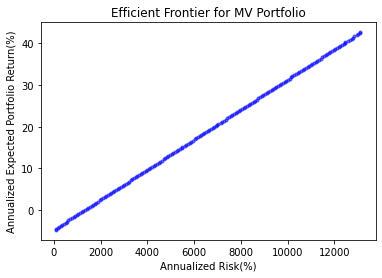

In [348]:
#Graph Efficient Frontier
import matplotlib.pyplot as plt

NoPoints = riskPoint.size

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for MV Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(riskPoint, retPoint, s=area, c=colours, alpha =0.5)
plt.show()

# Naive Portfolio

In [344]:
naive_risks = []
naive_returns = []

for x in np.arange(0, 1, 0.01):
  weights = [x, 1-x]
  risk = np.matmul((np.matmul(weights,cov)),np.transpose(weights)) * trading_days_in_year
  naive_risks.append(risk)

  #obtain expected portfolio annualized return for the 
  #efficient set portfolios, for trading days = 251
  ret = trading_days_in_year*(np.matmul(weights,r))
  naive_returns.append(ret)

#display efficient set portfolio parameters
# print("Size of the  efficient set:", xOptimalArray.shape )
# print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[naive_risks, naive_returns])

Annualized Risk and Return of the efficient set portfolios: 
 [[ 8.78386064e+03 -4.72959193e+00]
 [ 2.54698590e+04 -4.25411599e+00]
 [ 7.70578464e+04 -3.77864005e+00]
 [ 1.63547823e+05 -3.30316411e+00]
 [ 2.84939788e+05 -2.82768817e+00]
 [ 4.41233743e+05 -2.35221223e+00]
 [ 6.32429687e+05 -1.87673630e+00]
 [ 8.58527619e+05 -1.40126036e+00]
 [ 1.11952754e+06 -9.25784417e-01]
 [ 1.41542945e+06 -4.50308477e-01]
 [ 1.74623335e+06  2.51674620e-02]
 [ 2.11193924e+06  5.00643401e-01]
 [ 2.51254712e+06  9.76119341e-01]
 [ 2.94805699e+06  1.45159528e+00]
 [ 3.41846884e+06  1.92707122e+00]
 [ 3.92378269e+06  2.40254716e+00]
 [ 4.46399852e+06  2.87802310e+00]
 [ 5.03911634e+06  3.35349904e+00]
 [ 5.64913616e+06  3.82897498e+00]
 [ 6.29405796e+06  4.30445092e+00]
 [ 6.97388175e+06  4.77992686e+00]
 [ 7.68860753e+06  5.25540279e+00]
 [ 8.43823530e+06  5.73087873e+00]
 [ 9.22276505e+06  6.20635467e+00]
 [ 1.00421968e+07  6.68183061e+00]
 [ 1.08965305e+07  7.15730655e+00]
 [ 1.17857663e+07  7.6327824

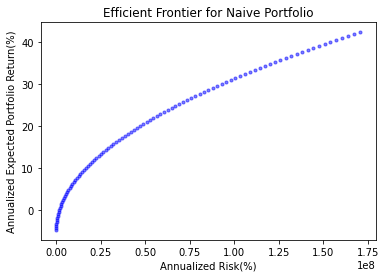

In [345]:
#Graph Efficient Frontier
import matplotlib.pyplot as plt

NoPoints = len(naive_risks)

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(naive_risks, naive_returns, s=area, c=colours, alpha =0.5)
plt.show()

# Combined Graph

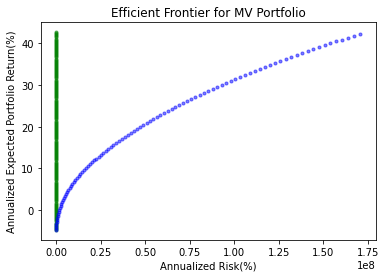

In [350]:
#Graph Efficient Frontier
import matplotlib.pyplot as plt

NoPoints = riskPoint.size

colours = "blue"
area = np.pi*3


fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.title('Efficient Frontier for MV Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
ax1.scatter(riskPoint, retPoint, s=area, c="green", alpha =0.5)
ax1.scatter(naive_risks, naive_returns, s=area, c="blue", alpha =0.5)
plt.show()